<img src="gwfish_priors_white.png" width="300" height="300"> 

# GWFish meets Priors
In Bayesian analysis, we start with prior beliefs about the parameters of the source, which represent our initial knowledge or assumptions. These priors can be informed by astrophysical models, previous observations, or theoretical predictions. As we observe the gravitational wave signal, we update these beliefs using the likelihood function, which quantifies the probability of observing the data given the parameters. The result is the posterior distribution, which represents our updated knowledge about the parameters after considering the data.

One of the advantages of the Bayesian approach is its ability to incorporate prior information and quantify uncertainties in a rigorous way. By combining prior knowledge with the observed data, we can make more informed inferences about the properties of the gravitational wave source.

$$p(\vec{\theta}|s) \propto \pi(\vec{\theta}){\mathcal{L}}(s|\vec{\theta})$$

The Fisher matrix analysis works in the assumption that when the signal to noise ratio (SNR) is sufficiently large, the likelihood is a highly peaked function and no priors are needed. However, this is rarely the case, as correlations may spread the likelihood and sampling from the multivariate Gaussian may leak outside the physical range of parameters. In the following tutorial we show how to incorporate prior information $\pi(\vec{\theta})$ on top of the Fisher likelihood, with a sampling procedure that stays computationally efficient.

The procedure is addressed in a second `GWFish` paper available on [arXiv](https://arxiv.org/abs/2404.16103). The usage of the code as for the paper's purposes can be found in this [repo](https://github.com/u-dupletsa/GWFish-meets-Priors).

### Introducing the new modules
This part is based on the new module `priors.py` and the sampling procedure relies on the `minimax_tilting_sampler.py` module (see below). It consists in building on top of the standard `GWFish`output and incorporate prior information in post-processing.

In [ ]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import GWFish.modules as gw
from GWFish.modules.priors import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
matplotlib.rc('xtick', labelsize = 12) 
matplotlib.rc('ytick', labelsize = 12)

matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = True

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

### Produce standard `GWfish` output
For a throughout guide refer to the main `gwfish_tutorial.ipynb`

In [ ]:
# Event's parameters should be passed as Pandas dataframe
parameters = {
    'chirp_mass': np.array([20]), 
    'mass_ratio': np.array([0.75]), 
    'luminosity_distance': np.array([1000.]),
    'theta_jn': np.array([np.pi/4]),
    'ra': np.array([np.pi/4]),
    'dec': np.array([np.pi/4]),
    'psi': np.array([np.pi/4]),
    'phase': np.array([np.pi/4]),
    'geocent_time': np.array([1187008882]),
    'a_1':np.array([0.2]), 
    'a_2':np.array([0.2]),
    'tilt_1':np.array([np.pi/4]),
    'tilt_2':np.array([np.pi/4]),
    'phi_12':np.array([np.pi/4]),
    'phi_jl':np.array([np.pi/4])}
parameters = pd.DataFrame(parameters)
parameters

,chirp_mass,mass_ratio,luminosity_distance,theta_jn,ra,dec,psi,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,phi_jl
0,20,0.75,1000.0,0.785398,0.785398,0.785398,0.785398,0.785398,1187008882,0.2,0.2,0.785398,0.785398,0.785398,0.785398


In [5]:
# The fisher parameters are the parameters that will be used to calculate the Fisher matrix
# and on which we will calculate the errors
fisher_parameters = list(parameters.keys())

In [17]:
detected, network_snr, parameter_errors, sky_localization = gw.fishermatrix.compute_network_errors(
        network = gw.detection.Network(detector_ids = ['LLO'], detection_SNR = (0., 8.)),
        parameter_values = parameters,
        fisher_parameters=fisher_parameters, 
        waveform_model = 'IMRPhenomXPHM',
        save_matrices = True # you need to save the covariance matrix for the next steps
        )

100%|██████████| 1/1 [00:03<00:00,  3.68s/it]


## Post-processing with priors

In [ ]:
np.random.seed(42) # fix for reproducibility
rng = np.random.default_rng()
# Decide the number of samples to draw
num_samples = int(1e6)

### Sampling from the multivariate-Gaussian 
We sample directly using the covariance matrix from `GWFish` without any prior on parameters

In [ ]:
param_lbs = {'chirp_mass': r'$\mathcal{M}_c$ $[M_{\odot}]$', 'mass_ratio': r'$q$', 'luminosity_distance': r'$d_L$ [Mpc]',
                'dec': r'$\texttt{DEC}$ [rad]', 'ra': r'$\texttt{RA}$ [rad]', 'theta_jn': r'$\theta_{JN}$ [rad]', 'psi': r'$\Psi$ [rad]',
                'phase': r'$\phi$ [rad]', 'geocent_time': r'$t_c$ [rad][s]', 'a_1': r'$a_1$', 'a_2': r'$a_2$',
                'tilt_1': r'$\theta_1$ [rad]', 'tilt_2': r'$\theta_2$ [rad]', 'phi_12': r'$\phi_{12}$ [rad]',
                'phi_jl': r'$\phi_{JL}$ [rad]'}
 
mean_values = np.array(parameters[fisher_parameters ].iloc[0]) # mean values of the parameters
cov_matrix = np.load('inv_fisher_matrices.npy')[0, :, :]
samples = rng.multivariate_normal(mean_values, cov_matrix, int(1e6))

## Minimax tilting sampling from truncated Gaussian
Some parameters (especially angles and spins), even with high SNR, may still be poorly measured and show a largely-spread likelihood. Consequently, when drawing likelihood samples, most samples lie outside the physical range of parameters. Therefore, we sample directly from the truncated form of the Gaussian likelihood to prevent drawing a large number of samples with null prior, which would have to be discarded. In particular, we rely on the algorithm developed in [Botev 2016](https://arxiv.org/abs/1603.04166) (we slighlty modified the code - publicly available on [GitHub](https://github.com/brunzema/truncated-mvn-sampler?tab=readme-ov-file)- based on this paper). This effectively accounts for the parameters' boundaries, ensuring the samples are in their physical range. 

The `minmax_tilting` algorithm explained in [Botev 2016](https://arxiv.org/abs/1603.04166) is roughly based on the following steps:
1. Identify target distribution for which direct sampling might be problematic (multi-dimensional truncated Gaussian)
2. Choose a family of tilting distributions that are easier to samples from (Gaussians in our case with adjustable parameters)
3. Choose best tilting parameters so that the maximum distance (the Kullback-Leibler (KL) divergence) between the auxiliar and the target distribution is minimized (hence *minimax*)
4. Sample from tilted distribution
5. Re-weight samples to match the target distribution

In [19]:
# In priors.py the finction get_truncated_likelihood_samples takes the following arguments:
# - fisher_parameters: list of parameters
# - mean_values: mean values of the parameters
# - cov_matrix: covariance matrix
# - num_samples: number of samples to draw
# - min_array: minimum values of the parameters
# - max_array: maximum values of the parameters
# The function returns the samples from the truncated likelihood
# If min_array and max_array are not provided, the function will use the default range for each parameter
# specified in the default prior dictionary (these ranges are used to truncate the likelihood)

samples_from_truncated_lkh = get_truncated_likelihood_samples(fisher_parameters, mean_values, cov_matrix, num_samples)#, min_array, max_array)

You are using custom ranges for the parameters!
You can pass a custom min_array and max_array to get_truncated_likelihood_samples()


In [20]:
# To avoid having a large number of samples outside the physical range, we apply the prior to the samples from
# the truncated likelihood. The function get_posteriors_samples takes the following arguments:
# - fisher_parameters: list of parameters
# - samples_from_truncated_lkh: samples from the truncated likelihood
# - num_samples: number of samples to draw
# - priors_dict: dictionary with the prior ranges for each parameter (if not provided, the default prior dictionary is used)

samples_from_posterior = get_posteriors_samples(fisher_parameters, samples_from_truncated_lkh, num_samples)#, priors_dict)

#############################################
You are using the default priors dictionary!
#############################################
#############################################
Provide a custom prior dictionary to change the priors in the format {'param_name': {'prior_type': 'prior_function', 'lower_prior_bound': lower_bound, 'upper_prior_bound': upper_bound}}
###################################################################################
To get a list of implemented prior functions, use get_available_prior_functions()
To get the default priors dictionary, use print_default_priors_dict(params)


In [13]:
print_default_priors_dict(fisher_parameters)

chirp_mass: uniform_in_component_masses_chirp_mass in the interval [5, 100]
mass_ratio: uniform_in_component_masses_mass_ratio in the interval [0.0, 0.99]
luminosity_distance: uniform_in_comoving_volume_and_source_frame in the interval [10, 10000]
theta_jn: uniform_in_sine in the interval [0, 3.141592653589793]
ra: uniform in the interval [0, 6.283185307179586]
dec: uniform_in_cosine in the interval [-1.5707963267948966, 1.5707963267948966]
psi: uniform in the interval [0, 3.141592653589793]
phase: uniform in the interval [0, 6.283185307179586]
geocent_time: uniform in the interval [0, 10000000000.0]
a_1: uniform in the interval [0, 0.99]
a_2: uniform in the interval [0, 0.99]
tilt_1: uniform_in_sine in the interval [0, 3.141592653589793]
tilt_2: uniform_in_sine in the interval [0, 3.141592653589793]
phi_12: uniform in the interval [0, 6.283185307179586]
phi_jl: uniform in the interval [0, 6.283185307179586]


In [14]:
injections = np.array(mean_values)
fisher_samples = pd.DataFrame(samples, columns = fisher_parameters)
fisher_truncated_samples = samples_from_truncated_lkh
fisher_plus_priors_samples = samples_from_posterior

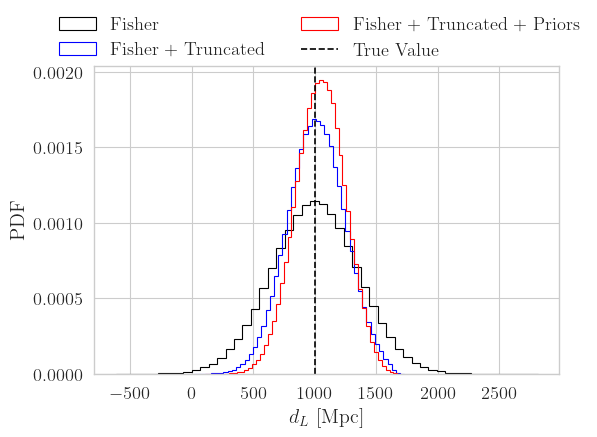

In [21]:
# Plot the posterior distribution of the parameter of choice
sel_param = 'luminosity_distance'

fig = plt.figure(figsize=(6, 4))
plt.hist(fisher_samples[sel_param], bins=50, histtype='step', density=True,
            label='Fisher', alpha = 1., color = 'black')
plt.hist(fisher_truncated_samples[sel_param], bins=50, histtype='step', density=True,
            label='Fisher + Truncated', alpha = 1., color = 'blue')
plt.hist(fisher_plus_priors_samples[sel_param], bins=50, histtype='step', density=True,
            label='Fisher + Truncated + Priors', alpha = 1., color = 'red')
plt.axvline(injections[fisher_parameters.index(sel_param)], color='black', linestyle='--', label='True Value')
plt.xlabel(param_lbs[sel_param])
plt.ylabel('PDF')
fig.legend(loc='center', bbox_to_anchor=(0.5, 0.95), ncol=2, frameon=False)
plt.show()

### Priors dictionary example

In [16]:
priors_dict = {}
priors_dict['chirp_mass'] = {
    'prior_type': 'uniform_in_component_masses_chirp_mass',
    'lower_prior_bound': parameters['chirp_mass'].iloc[0] - 5.,
    'upper_prior_bound': parameters['chirp_mass'].iloc[0] + 5.
}
priors_dict['mass_ratio'] = {
    'prior_type': 'uniform_in_component_masses_mass_ratio',
    'lower_prior_bound': 0.05,
    'upper_prior_bound': 0.99
}
priors_dict['luminosity_distance'] = {
    'prior_type': 'uniform_in_distance_squared',
    'lower_prior_bound': 10,
    'upper_prior_bound': 10000
}
priors_dict['theta_jn'] = {
    'prior_type': 'uniform_in_sine',
    'lower_prior_bound': 0,
    'upper_prior_bound': np.pi
}
priors_dict['ra'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}
priors_dict['dec'] = {
    'prior_type': 'uniform_in_cosine',
    'lower_prior_bound': -np.pi/2,
    'upper_prior_bound': np.pi/2
}
priors_dict['psi'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': np.pi
}
priors_dict['phase'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}
priors_dict['geocent_time'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': parameters['geocent_time'].iloc[0] - 3,
    'upper_prior_bound': parameters['geocent_time'].iloc[0] + 3
}
priors_dict['a_1'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 1.
}
priors_dict['a_2'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 1.
}
priors_dict['tilt_1'] = {
    'prior_type': 'uniform_in_sine',
    'lower_prior_bound': 0.,
    'upper_prior_bound': np.pi
}
priors_dict['tilt_2'] = {
    'prior_type': 'uniform_in_sine',
    'lower_prior_bound': 0.,
    'upper_prior_bound': np.pi
}
priors_dict['phi_12'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}
priors_dict['phi_jl'] = {
    'prior_type': 'uniform',
    'lower_prior_bound': 0.,
    'upper_prior_bound': 2*np.pi
}